In [4]:
from Fetcher_EM import *

import os 
import sys 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
    

from QUANTAXIS.QAUtil.QADate_trade import (
    QA_util_get_pre_trade_date,
    QA_util_get_next_trade_date,
    QA_util_if_tradetime,
    QA_util_if_trade
)

import tools.Sample_Tools as smpl

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import QUANTAXIS as QA

import Analysis_Funs as af
import numpy as np
import pandas as pd

from base.JuUnits import roll_multi_result


%load_ext autoreload
%autoreload 2
%aimport Fetcher_EM,tools.Sample_Tools, Analysis_Funs

In [671]:
############股票

year = 2017
startday=str(year)+'-01-01'
endday=str(year)+'-12-31'

north_deal = fetch_north_deal_day(direct='north_', start=str(year-1)+'-06-30', end=endday).data.reset_index('code')
rankrate = north_deal['volume'].rolling(90).apply(lambda x: x.rank(pct=True)[-1])
benchmark = smpl.get_index_data('000300', start=str(year-1)+'-06-30', end=endday).data.reset_index('code')

mix_df = pd.DataFrame([north_deal['volume'],benchmark['close'].pct_change()]).T.dropna()
mix_df['cor']=roll_multi_result(mix_df, lambda x: np.corrcoef(x.T[1].tolist(), x.T[2].tolist())[0][1], 30, 1).T[0]


tmp = fetch_north_10top_direct(direct='north', start=startday, end=endday)
tmp['period'] = tmp.index.to_period('M')
unique_m = tmp.groupby('period').apply(lambda x: x.drop_duplicates(subset=['stock_name'],keep='first'))
unique_m = unique_m[~unique_m.stock_name.str.contains('^ST', na=False)]

res_list=[]
for index, row in unique_m.iterrows():
    if row['net_buy_amount']<0:
        continue
    if row['rank']>5:
        continue
    
    if rankrate.loc[row.name[1]] < 0.8:
        continue
    
    if mix_df['cor'].loc[row.name[1]] < 0.5:
        continue
    
#     if not (row['buy_amount'] > row['sell_amount']*1.5):
#         continue    
    start_day = pd.to_datetime(row['date_stamp']+86400,unit ='s')
    try:
        stock = smpl.get_data(row['stock_code'],start=start_day,gap=60).data
    except :
        continue
    count = len(stock)
    if count < 40:
#         print('{:s},{:s},{:d},数据不足，跳过'.format(row['stock_code'],row['stock_name'],count))
        continue
        
    item = {}
    item['stock_code'] = row['stock_code']
    item['stock_name'] = row['stock_name']
    item['stock_0date'] = stock.iloc[0].name[0]
    item['em_date'] = pd.to_datetime(row['date_stamp'],unit ='s')
    
    price_0 = stock.iloc[0].close
#     price_0 = stock.iloc[0].high*0.5 + stock.iloc[0].low*0.5
    item['0'] = price_0
    for i in [1,3,5,15,30]:
        item[str(i)] = stock.iloc[i].close/price_0 - 1
#         item[str(i)] = (stock.iloc[i].high*0.5 + stock.iloc[i].low*0.5)/price_0 - 1
    res_list.append(item)


df = pd.DataFrame(res_list)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 999):
#     print(df)

print(len(df))
(df.iloc[:,5:]>0).sum()/df.shape[0]

# df.iloc[:,5:].sum()

12


1     0.833333
3     0.666667
5     0.833333
15    0.833333
30    0.916667
dtype: float64

In [911]:
############行业

year = 2020
startday=str(year)+'-01-01'
endday=str(year)+'-12-31'

north_deal = fetch_north_deal_day(direct='north_', start=str(year-1)+'-06-30', end=endday).data.reset_index('code')
rankrate = north_deal['volume'].rolling(90).apply(lambda x: x.rank(pct=True)[-1])
benchmark = smpl.get_index_data('000300', start=str(year-1)+'-06-30', end=endday).data.reset_index('code')

mix_df = pd.DataFrame([north_deal['volume'],benchmark['close'].pct_change()]).T.dropna()
mix_df['cor']=roll_multi_result(mix_df, lambda x: np.corrcoef(x.T[1].tolist(), x.T[2].tolist())[0][1], 30, 1).T[0]


tmp = fetch_north_10top_direct(direct='north', start=startday, end=endday)
tmp = tmp[tmp['net_buy_amount']>0]
tmp['period'] = tmp.index.to_period('M')
unique_m = tmp.groupby('period').apply(lambda x: x.drop_duplicates(subset=['stock_name'],keep='first'))
unique_m = unique_m[~unique_m.stock_name.str.contains('^ST', na=False)]

res_list=[]
for index, row in unique_m.iterrows():
#     if row['net_buy_amount']<0: #已上移
#         continue
    if row['rank']>5:
        continue
    
    if rankrate.loc[row.name[1]] < 0.8:
        continue
    
    if mix_df['cor'].loc[row.name[1]] < 0.5:
        continue
    
#     if not (row['buy_amount'] > row['sell_amount']*1.5):
#         continue
    start_day = pd.to_datetime(row['date_stamp']+86400,unit ='s')
    
    try:
        bl = fetcher_block_info(row['stock_code'], hy_source='industry')
        bl_code = bl['blockcode'].tolist()[0]
        bl_name = bl['blockname'].tolist()[0]
        stock = fetch_block_index_day(block_code=bl_code,start=start_day,end=QA_util_get_next_trade_date(start_day,60)).data
        pre_day = fetch_block_index_day(block_code=bl_code, start=QA_util_get_pre_trade_date(start_day,2),end=QA_util_get_next_trade_date(start_day,1)).data.pct_change()
        pre_day_pct1 = pre_day.iloc[1]['close']
        pre_day_pct2 = pre_day.iloc[2]['close']
#         stock = smpl.get_data(row['stock_code'],start=start_day,gap=60).data
    except :
        continue
    count = len(stock)
    if count < 40:
#         print('{:s},{:s},{:d},数据不足，跳过'.format(row['stock_code'],row['stock_name'],count))
        continue
        
    item = {}
    item['block_code'] = bl_code
    item['block_name'] = bl_name
    item['stock_code'] = row['stock_code']
    item['stock_name'] = row['stock_name']
    item['stock_0date'] = stock.iloc[0].name[0]
    item['em_date'] = pd.to_datetime(row['date_stamp'],unit ='s')
    
#     price_0 = stock.iloc[0].high*0.5 + stock.iloc[0].low*0.5
    price_0 = stock.iloc[0].close
    item['0'] = price_0
    item['-0'] = pre_day_pct1
    item['-1'] = pre_day_pct2
    for i in [1,3,5,15,30]:
        item[str(i)] = stock.iloc[i].close/price_0 - 1
#         item[str(i)] = (stock.iloc[i].high*0.5 + stock.iloc[i].low*0.5)/price_0 - 1

    res_list.append(item)


df = pd.DataFrame(res_list)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 999):
#     print(df)

print(len(df))
(df.iloc[:,7:]>0).sum()/df.shape[0]

# df.iloc[:,5:].sum()

35


-0    0.942857
-1    0.514286
1     0.485714
3     0.514286
5     0.514286
15    0.514286
30    0.628571
dtype: float64

In [1033]:
############个股跟踪

year = 2020
startday=str(year)+'-01-01'
endday=str(year)+'-12-31'

north_deal = fetch_north_deal_day(direct='north_', start=str(year-1)+'-06-30', end=endday).data.reset_index('code')
rankrate = north_deal['volume'].rolling(90).apply(lambda x: x.rank(pct=True)[-1])
benchmark = smpl.get_index_data('000300', start=str(year-1)+'-06-30', end=endday).data.reset_index('code')

mix_df = pd.DataFrame([north_deal['volume'],benchmark['close'].pct_change()]).T.dropna()
mix_df['cor']=roll_multi_result(mix_df, lambda x: np.corrcoef(x.T[1].tolist(), x.T[2].tolist())[0][1], 30, 1).T[0]

benchmark_ma = QA.MA(benchmark['close'],10)
benchmark_direct = np.sign(benchmark_ma - benchmark_ma.shift(5))


tmp = fetch_north_10top_direct(direct='north', start=startday, end=endday)
tmp = tmp[tmp['net_buy_amount']>0]
tmp['period'] = tmp.index.to_period('M')
unique_m = tmp.groupby('period').apply(lambda x: x.drop_duplicates(subset=['stock_name'],keep='first'))
unique_m = unique_m[~unique_m.stock_name.str.contains('^ST', na=False)]
unique_m = unique_m[~unique_m.stock_code.str.contains('^3', na=False)]

res_list=[]
for index, row in unique_m.iterrows():
#     if row['net_buy_amount']<0: #已上移
#         continue
    if not row['rank'] in [3,4,5,6,7,8,9,10]:
        continue
    
    if rankrate.loc[row.name[1]] < 0.8:
        continue
    
#     if abs(mix_df['cor'].loc[row.name[1]]) < 0.5:
#         continue
    
    if benchmark_direct.loc[row.name[1]] >= 0:
        if mix_df['cor'].loc[row.name[1]] < 0.5:
            continue
    else:
        if mix_df['cor'].loc[row.name[1]] < -0.5:
            continue
        
    start_day = pd.to_datetime(row['date_stamp']+86400,unit ='s')
    try:
        stock = smpl.get_data(row['stock_code'],start=start_day,gap=60).data
    except :
        print('{:s},获取出错'.format(row['stock_code'],count))
        continue
        
#     count = len(stock)
#     if count < 40:
# #         print('{:s},{:s},{:d},数据不足，跳过'.format(row['stock_code'],row['stock_name'],count))
#         continue
        
    item = {}
    item['stock_code'] = row['stock_code']
    item['stock_name'] = row['stock_name']
    item['em_date'] = pd.to_datetime(row['date_stamp'],unit ='s')
    
    try:
        ret = stock.close.pct_change()
        ret[0] = (stock.close.iloc[0]-stock.open.iloc[0])/stock.open.iloc[0]
#         for i in [0,1,2,3]:
#             idx = np.where(ret<0)[0][i]
#             item['return-'+str(i)] = ret[:idx+1].sum()
#             item['durate-'+str(i)] = idx
#             item['back-'+str(i)] = ret[idx]
        ret_cum = ret.cumsum()
        lost_cum = 0
        stop_idx = 0
        for i in np.where(ret<0)[0]:
            stop_idx = i
            lost_cum += ret[i]
#             if abs(ret[i]) > ret_cum[i]*0.2:
# #                 if stop_idx == 0:
# #                     continue
#                 break

            if stop_idx > 0:
                if ret_cum[i] < ret_cum[:i+1].max()/2:
                    break
            
            if ret[i] < -0.05:
                break
            if lost_cum < -0.1:
                break
        
        item['return0'] = ret[0]
        item['return'] = ret_cum[stop_idx]
        item['durate'] = stop_idx
        item['cumback'] = lost_cum
        
        
#         if row['stock_code'] == '600519':
#             with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 999):
#                 print(ret)
    except :
        print('越界')
        continue
    
    
    res_list.append(item)


df = pd.DataFrame(res_list)
print(len(df))
print((df['return']>0).sum()/df.shape[0])
print(df['return'].sum()/len(df))
print(df['return0'].sum())
print(df['return'].sum())
print(df.groupby('em_date').apply(lambda x: x['return0'].mean()).sum())
print(df.groupby('em_date').apply(lambda x: x['return'].mean()).sum())


with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 999):
    print(df)



139
0.5467625899280576
0.029908392466830254
1.2973184916632137
4.157266552889405
0.23032811021608712
1.3569420924058486
    stock_code stock_name    em_date   return0    return  durate   cumback
0       600009       上海机场 2020-02-03  0.049231  0.057556      15 -0.105561
1       600276       恒瑞医药 2020-02-03  0.015332  0.035803      14 -0.090163
2       600036       招商银行 2020-02-03  0.008847  0.001894       4 -0.018265
3       600887       伊利股份 2020-02-03  0.030705  0.037295      15 -0.083697
4       601888       中国中免 2020-02-03  0.017344  0.087193      16 -0.117586
5       600585       海螺水泥 2020-02-03  0.047261  0.244578      23 -0.129993
6       601166       兴业银行 2020-02-03  0.019175  0.006038      18 -0.085470
7       600031       三一重工 2020-02-03  0.070188  0.259991      20 -0.104484
8       002304       洋河股份 2020-02-03  0.003528  0.016482       4 -0.020095
9       002415       海康威视 2020-02-03  0.041438  0.069693      18 -0.145365
10      002714       牧原股份 2020-02-03  0.079035  0.57256

<AxesSubplot:label='19fdeb59-0350-47f1-beff-181ace2867b6'>

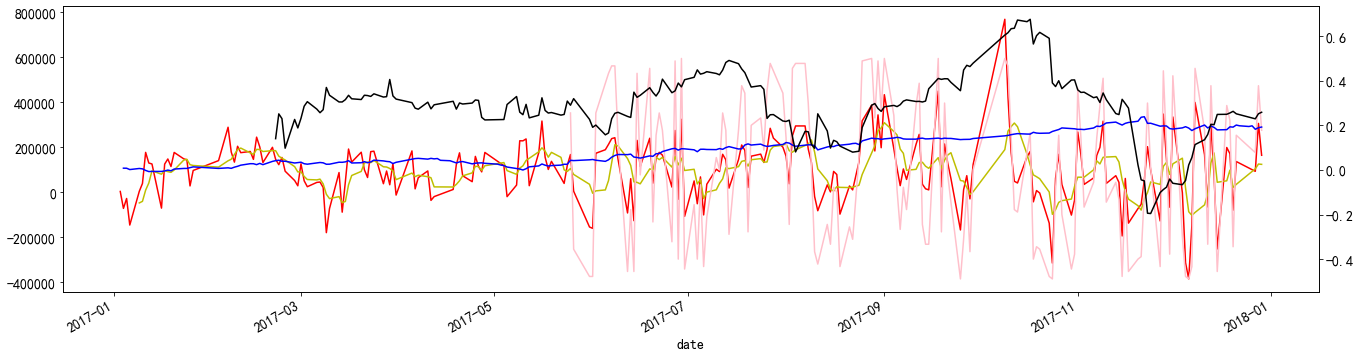

In [536]:
year = '2017'
startday=year+'-01-01'
endday=year+'-12-31'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 999):
#     print(fetch_north_deal_day(direct='north_', start=startday, end=endday).data.reset_index('code')['volume'])

fig = plt.figure(figsize=(1620/72,420/72))
north_deal = fetch_north_deal_day(direct='north_', start=startday, end=endday).data.reset_index('code')
north_deal['volume'].plot(color='r')
QA.MA(north_deal['volume'],5).plot(color='y')
north_deal['volume'].rolling(90).apply(lambda x: x.rank(pct=True)[-1]-0.5).plot(color='pink',secondary_y=["volume"])

benchmark = smpl.get_index_data('000300', start=startday, end=endday).data.reset_index('code')
benchmark['close'].pct_change().cumsum().plot(secondary_y=['close'],color='b')

mix = pd.DataFrame([north_deal['volume'],benchmark['close'].pct_change()]).T.dropna()
mix['cor']=roll_multi_result(mix, lambda x: np.corrcoef(x.T[1].tolist(), x.T[2].tolist())[0][1], 30, 1).T[0]
mix['cor'].plot(secondary_y=['cor'],color='black')


In [528]:
# for i in range(6):
#     year = str(2016+i)
#     startday=year+'-01-01'
#     endday=year+'-12-31'

#     fig = plt.figure()
#     north_deal = fetch_north_deal_day(direct='north_', start=startday, end=endday).data.reset_index('code')
#     benchmark = smpl.get_index_data('000300', start=startday, end=endday).data.reset_index('code')

#     mix = pd.DataFrame([north_deal['volume'],benchmark['close'].pct_change()]).T
#     mix = mix.dropna()
#     mix['cor']=roll_multi_result(mix, lambda x: np.corrcoef(x.T[1].tolist(), x.T[2].tolist())[0][1], 30, 1).T[0]
#     mix['cor'].plot()
#     (benchmark['close'].pct_change().cumsum()).plot()
#     plt.show()

In [589]:
def test():
    ...
    
df

,stock_code,stock_name,stock_0date,em_date,0,1,3,5,15,30
0,000333,美的集团,2020-04-08,2020-04-07,48.395,-0.001343,0.031925,0.038124,0.073665,0.183283
1,300059,东方财富,2020-05-11,2020-05-08,18.345,-0.010084,-0.016626,-0.018806,-0.174162,0.028618
2,002352,顺丰控股,2020-06-01,2020-05-29,46.750,0.041604,0.067166,0.100321,0.174652,0.418182
3,600519,贵州茅台,2020-06-02,2020-06-01,1417.280,-0.007511,-0.001623,-0.003133,0.028562,0.174754
4,600276,恒瑞医药,2020-06-02,2020-06-01,80.065,0.003497,0.016299,0.019796,0.164679,0.251608
5,601318,中国平安,2020-06-02,2020-06-01,73.270,0.035144,0.022519,0.047496,-0.015491,0.092330
6,600009,上海机场,2020-06-02,2020-06-01,73.855,-0.001219,-0.002505,0.022273,-0.041703,-0.026809
7,600585,海螺水泥,2020-06-02,2020-06-01,57.720,0.003638,-0.031532,-0.022956,-0.072678,-0.010222
8,000858,五粮液,2020-06-02,2020-06-01,160.835,-0.010041,-0.010539,0.001057,0.027388,0.313800
9,002475,立讯精密,2020-06-02,2020-06-01,48.380,0.035449,0.054258,0.062009,-0.005167,0.148408


In [5]:
QA.QA_fetch_stock_day_full_adv('2020-12-18').data

open    high     low   close     volume
date       code                                             
2020-12-18 000001   19.00   19.10   18.23   18.36  1058756.0
           000002   28.84   28.85   28.35   28.50   525459.0
           000004   23.17   23.17   22.48   22.67    28426.0
           000005    2.54    2.57    2.53    2.54    61197.0
           000006    5.47    5.53    5.46    5.52    58599.0
...                   ...     ...     ...     ...        ...
           688699   82.27   96.16   82.00   83.98   123104.0
           688777   99.70  100.96   95.00   96.00    31872.0
           688788  192.60  196.69  185.16  187.00    11488.0
           688981   57.00   57.00   54.75   55.02   302636.0
           689009   73.70   75.50   71.86   71.98    76357.0

[4100 rows x 5 columns]

In [219]:
# %%time
tmp = smpl.get_data('000001',start='2019-01-15',gap=60).data.close




In [392]:
# ttmp = np.array([93,10,61,15,53,80,96,67,66,45,1,91,43,81,63,28,72,39,67,96,21,90,23,1,9,92,52,24,69,59,43,88,19,89,81,56,83,98,82,92,17,21,3,93,26,88,17,82,67,66,98,82,18,46,60,10,53,11,53,85,22,99,15,47,53,18,14,55,96,1,73,100,32,33,62,4,91,91,84,35,7,83,81,56,84,73,55,100,32,64,42,70,66,78,39,93,22,16,28,18,72,66,22,66,28,32,60,99,46,51,19,49,45,42,26,54,69,26,72,11,25,13,38,93,73,2,18,35,4,53,1,71,47,50,37,2,32,67,36,90,30,89,23,78,4,46,16,74,11,31,76,37,12,41,38,27,65,35,93,45,28,86,79,89,64,96,88,71,4,50,86,84,2,70,61,46,11,73,19,35,56,68,59,32,37,60,47,68,15,35,57,62,91,61,65,21,50,67,79,84,83,69,12,32,72,90,48,98,52,5,77,4,45,3,18,57,28,39,42,49,86,98,19,47,39,5,66,25,25,60,81,48,32,26,31,71,56,87,64,51,14,52,71,67,81,63,31,26,95,74,80,74,57,61,62,4,33,79,69,33,21,33,37,90,99,59,76,72,81,68,50,4,98,30,7,37,51,29,74,53,60,25,71,93,87,52,28,98,21,80,27,55,55,25,26,59,26,10,20,53,60,87,92,14,49,62,73,63,67,53,64,64,76,36,89,65,94,79,52,98,76,25,64,79,81,16,19,79,63,95,43,50,4,84,14,86,63,61,87,85,85,50,2,30,20,95,23,41,49,39,1,37,62,82,59,84,58,81,3,22,27,56,88,58,26,0,11,44,53,93,31,37,23,58,76,18,76,71,69,15,16,20,43,64,31,21,7,98,40,20,21,43,95,21,32,94,7,36,3,47,5,96,32,99,63,22,74,39,3,45,23,40,59,77,90,72,37,39,69,61,1,90,4,34,52,87,80,43,17,20,86,66,78,81,51,58,70,25,85,74,50,17,56,2,67,80,83,72,11,57,32,77,99,95,41,82,90,55,21,30,0,72,13,77,18,86,75,12,67,99,93,76,25,42,7,0,58,37,59,63,67,36,27,24,15,40,52,76,84,39,92,9,57,10,84,41,16,53,36,13,1,93,4,65,93,54,60,26,98,26,39,42,14,51,31,2,79,62,22,18,36,79,37,53,23,32,82,91,24,16,77,4,5,72,74,69,73,96,10,16,75,66,49,70,42,71,45,79,79,0,46,39,58,66,68,5,49,26,19,15,48,84,75,49,73,92,6,20,83,26,30,73,29,20,42,97,45,85,36,0,46,88,36,19,16,12,34,0,10,23,29,97,72,24,39,28,21,19,10,91,79,39,52,47,60,12,60,61,75,30,68,80,43,79,45,51,58,67,59,56,44,30,35,46,69,71,83,14,37,71,20,8,38,82,95,48,89,46,61,58,93,31,77,58,2,84,67,78,52,59,44,56,94,26,97,61,33,59,32,40,68,95,56,38,95,22,2,31,60,59,10,52,27,5,32,80,27,57,70,51,62,84,14,86,88,69,67,74,57,18,37,85,15,28,92,15,14,93,6,10,69,97,78,44,9,85,7,27,38,34,60,19,88,91,62,52,30,68,83,99,87,88,67,2,59,19,73,32,73,41,22,56,47,100,2,69,28,64,43,29,84,82,87,66,49,66,15,43,58,4,97,23,23,97,88,78,92,75,85,21,46,88,91,20,14,43,65,6,11,100,100,54,50,44,72,87,17,65,2,95,5,3,87,29,26,13,38,84,21,29,83,31,48,60,45,72,41,9,56,90,99,55,37,66,96,34,87,29,4,61,72,13,4,15,83,17,54,1,6,93,72,52,71,6,82,55,70,95,91,27,40,33,70,21,64,82,88,31,87,2,99,5,65,15,56,85,18,91,44,22,77,50,32,55,79,64,36,86,57,51,76,49,16,91,53,47,44,93,4,82,57,51,78,80,18,67,20,86,60,73,11,54,38,79,77,100,14,28,86,47,36,13,99,17,27,23,31,6,26,40,53,18,30,44,82,96,62,97,82,95,77,94,65,93,4,7,38,22,41,15,25,33,80,59,65,23,28,62,8,37,12,4,16,68,60,69,57,35,32,80,26,7,17,53,100,8,15,60,94,35,34,1,86,34,67,78,74,29,77,34,92,97,89,91,77,57,90,69,51,40,67,87,60,4,99,28,45,4,4,21,91,77,43,86,6,52,70,39,29,50,94,2,42,98,31,56,61,77,25,19,33,93,28,41,86,89,93,95,81,17,75,54,77,88,37,64,27,5,54,79,97,60,45,42,12,48,88,43,58,51,85,2,39,31,46,74,27,52,98,10,73,89,88,71,95,49,42,53,29,15,96,28,71,94,80,70,20,59,25,5,93,53,21,83,80,11,92,43,12,37,95,99,56,98,91,56,65,93,94,52,13,72,72,15,43,68,17,8,83,43,96,11,48,11,90,82,38,16,81,32,77,31,11,100,75,47,58,36,21,98,86,24,35,2,34,79,20,5,14,44,2,44,62,14,22,28,91,49,30,21,90,28,89,40,86,81,75,36,8,90,98,86,70,7,7,87,44,4,80,23,10,74,30,38,88,64,14,67,85,40,33,68,93,29,62,46,33,74,39,73,80,35,0,36,11,70,53,56,24,11,87,8,44,29,43,93,96,37,69,95,97,4,32,53,39,31,54,61,36,78,99,16,1,89,85,39,10,13,94,23,45,10,39,76,7,64,7,24,0,22,41,46,26,14,22,34,46,11,15,9,9,6,46,83,55,67,50,53,37,76,36,85,56,79,83,70,78,5,35,88])

# ttmp = np.random.normal(50, 20, 1250)
# ttmp = np.random.wald(50, 20, 1250)

# ttmp = np.random.random(1250)
# ttmp = np.random.randint(30, 70, 1250)
# ttmp = np.random.exponential(1.5, 1250)
# ttmp = np.random.poisson(1.5, 1250)

# tmp = smpl.get_data('000006',start='2017-01-15',gap=252).data.close
# ttmp = tmp.values


# widow = 110

# %time cor,fiited = af.poly_effectiveness(ttmp, widow, 5, get_fitted=True)

# fig = plt.figure(figsize=(1620/72,350/72))
# pd.Series(ttmp).plot()
# pd.Series(fiited).plot()

# print(cor)



In [10]:
# rps_returns['rps_ret'].to_list()
# import numba as nb
abc = smpl.get_data(['000002'],start='2010-01-15',gap=66).data
hlc = abc[['high','low','close']]



In [662]:
%%time
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
# axa = RPS_rank_backward(abc)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(axa)

Wall time: 0 ns


In [5]:
import numba as nb
import talib
import scipy.optimize as opt
from matplotlib import patches
import math

@nb.jit(nopython=True)
def renko_chart(price_series, N, condensed=True):
    """
    原版代码来自QUANTAXIS QA.RENKO，经过numba jit优化，最终输出格式统一为
    2维数组，4列数据：price/Lower Band/Upper Band/Direction
    """
    idx_renko_price = 0
    idx_renko_direction = 1
    idx_renko_lb = 2
    idx_renko_ub = 3
    ret_renko_chart = np.empty((len(price_series), 4,))

    last_price = price_series[0]
    chart = [last_price]
    for i in range(0, len(price_series)):
        price = price_series[i]
        bricks = math.floor(abs(price - last_price) / N)
        if bricks == 0:
            if condensed:
                ret_renko_chart[i, idx_renko_price] = chart[-1]
                chart.append(chart[-1])
            continue
        sign = int(np.sign(price - last_price))
        #print(price_series[i-1], price_series[i], [sign * (last_price + (sign
        #* N * x)) for x in range(1, bricks + 1)])
        chart += [sign * (last_price + (sign * N * x)) for x in range(1, bricks + 1)]
        ret_renko_chart[i, idx_renko_price] = chart[-1]
        last_price = abs(chart[-1])

    ret_renko_chart[:, idx_renko_direction] = np.sign(ret_renko_chart[:, idx_renko_price])
    ret_renko_chart[:, idx_renko_lb] = np.where(ret_renko_chart[:, idx_renko_direction] < 0,
                                                -ret_renko_chart[:, idx_renko_price] - N,
                                                ret_renko_chart[:, idx_renko_price])
    ret_renko_chart[:, idx_renko_ub] = np.where(ret_renko_chart[:, idx_renko_direction] > 0,
                                                ret_renko_chart[:, idx_renko_price] + N,
                                                -ret_renko_chart[:, idx_renko_price])

    return ret_renko_chart



In [7]:
class renko:
    """
    Renko Chart/Renko Brick/Renko Bar
    A renko chart is a type of financial chart of Japanese origin used in 
    technical analysis that measures and plots price changes.
    Renko砖块图是一种由日本人发明的用于衡量和绘制价格变化的财务技術分析图表。Renko图由砖块
    组成，与典型的蜡烛图相比，它可以通过剔除噪音的方式，帮助投资者更好的分析趋势和进行量化研究，
    更清晰地显示市场趋势并提高信噪比。
    """
    def __init__(self, hlc=None):
        """
        Inti data, 
        params
        ---------
        hlc:ndarray | optial, with hlc/ohlc price data

        初始化数据
        可选参数---
        hlc: ndarray | optial, 包含 3/4 列 hlc/ohlc 价格信息
        """
        self.source_prices = []
        self.renko_prices = []
        self.renko_directions = []

        self.source_aligned = []
        self.renko_gaps = []

        # 增加上下影线
        # For upper lower shadow
        self.renko_upper_shadow = []
        self.renko_lower_shadow = []

        if ((hlc is not None) and (len(hlc) > 0)):
            if (len(hlc[0, :]) == 3):
                self.source_hlc = hlc
            elif (len(hlc[0, :]) >= 4):
                self.source_hlc = hlc[:, [1, 2, 3]]
            else:
                print(u'renko(hlc) must has 3~4 columns data with high, low, close price.')
                self.source_hlc = []
        else:
            self.source_hlc = []
        
    def set_brick_size(self, HLC_history=None, auto=True, brick_size=10.0):
        """
        Setting brick size.  Auto mode is preferred, it uses history
        """
        if (isinstance(HLC_history, np.ndarray)):
            HLC_history = HLC_history[:, [0, 1, 2]]
        elif (isinstance(HLC_history, pd.DataFrame)):
            HLC_history = HLC_history.iloc[:, [0, 1, 2]].values

        if auto == True:
            self.brick_size = self.__get_optimal_brick_size(HLC_history)
        else:
            self.brick_size = brick_size
        return self.brick_size
    
    def __renko_rule(self, last_price, aligned_idx=0):
        """
        Renko brick increasing rule
        """
        # Get the gap between two prices
        gap_div = int(float(last_price - self.renko_prices[-1]) / self.brick_size)
        is_new_brick = False
        start_brick = 0
        num_new_bars = 0

        # When we have some gap in prices
        if gap_div != 0:
            # Forward any direction (up or down)
            if (gap_div > 0 and (self.renko_directions[-1] > 0 or self.renko_directions[-1] == 0)) or (gap_div < 0 and (self.renko_directions[-1] < 0 or self.renko_directions[-1] == 0)):
                num_new_bars = gap_div
                is_new_brick = True
                start_brick = 0
            # Backward direction (up -> down or down -> up)
            elif np.abs(gap_div) >= 2: # Should be double gap at least
                num_new_bars = gap_div
                num_new_bars -= np.sign(gap_div)
                start_brick = 2
                is_new_brick = True

                next_price = self.renko_prices[-1] + 2 * self.brick_size * np.sign(gap_div)
                self.renko_prices.append(next_price)
                self.renko_directions.append(np.sign(gap_div))

                # 记录上下影线
                if (len(self.source_hlc) > 0):
                    self.renko_upper_shadow.append(self.source_hlc[aligned_idx, 0])
                    self.renko_lower_shadow.append(self.source_hlc[aligned_idx, 1])
                self.renko_gaps.append(aligned_idx)
            #else:
                #num_new_bars = 0

            if is_new_brick:
                # Add each brick
                for d in range(start_brick, np.abs(gap_div)):
                    next_price = self.renko_prices[-1] + self.brick_size * np.sign(gap_div)
                    self.renko_prices.append(next_price)
                    self.renko_directions.append(np.sign(gap_div))

                    # 记录上下影线
                    if (len(self.source_hlc) > 0):
                        self.renko_upper_shadow.append(self.source_hlc[aligned_idx, 0])
                        self.renko_lower_shadow.append(self.source_hlc[aligned_idx, 1])
                    self.renko_gaps.append(aligned_idx)

        return num_new_bars
    
    def build_history(self, prices=None, hlc=None):
        """
        Getting renko on history
        生成 Renko brick 序列（非时间顺序，按时间顺序的 Renko 序列在）
        """
        if ((hlc is not None) and (len(hlc) > 0)):
            if (len(hlc[0, :]) == 3):
                prices = hlc[:, 2]
                self.source_hlc = hlc
            elif (len(hlc[0, :]) >= 4):
                prices = hlc[:, 3]
                self.source_hlc = hlc[:, [1, 2, 3]]
            else:
                print(u'renko.build_history(hlc) must has 3~4 columns data with high, low, close price.')

        if len(prices) > 0:
            # Init by start values
            self.source_prices = prices
            self.renko_prices.append(prices[0])
            self.renko_directions.append(0)

            # 记录上下影线
            if (len(self.source_hlc) > 0):
                self.renko_upper_shadow.append(self.source_hlc[0, 0])
                self.renko_lower_shadow.append(self.source_hlc[0, 1])

            self.source_aligned = np.empty((len(prices),3))
        
            # For each price in history
            idx = 1
            for p in self.source_prices[1:]:
                ret_new = self.__renko_rule(p, idx)

                # 同步Renko线到真实K线时间
                # Align Renko Price to real ohlc‘s xlim
                if (len(self.renko_prices) <= 1) or \
                    ((len(self.renko_prices) > 1) and (abs(self.renko_prices[-1] - self.renko_prices[-2]) == self.brick_size)):
                    self.source_aligned[idx, 0] = self.renko_prices[-1] - self.brick_size if self.renko_directions[-1] == 1 else self.renko_prices[-1]
                    self.source_aligned[idx, 1] = self.renko_prices[-1] if self.renko_directions[-1] == 1 else self.renko_prices[-1] - self.brick_size
                else:
                    # 跳空
                    self.source_aligned[idx, 0] = self.renko_prices[-1] + self.brick_size if self.renko_directions[-1] == 1 else self.renko_prices[-1]
                    self.source_aligned[idx, 1] = self.renko_prices[-1] if self.renko_directions[-1] == 1 else self.renko_prices[-1] + self.brick_size
                self.source_aligned[idx, 2] = self.renko_directions[-1]

                # 记录上下影线
                if (len(self.source_hlc) > 0):
                    self.renko_upper_shadow[-1] = self.renko_upper_shadow[-1] if (self.renko_upper_shadow[-1] > self.source_hlc[idx, 0]) else self.source_hlc[idx, 0]
                    self.renko_lower_shadow[-1] = self.renko_lower_shadow[-1] if (self.renko_lower_shadow[-1] < self.source_hlc[idx, 1]) else self.source_hlc[idx, 1]

                idx = idx + 1

        return len(self.renko_prices)
    
    # Getting next renko value for last price
    def do_next(self, last_price):
        if len(self.renko_prices) == 0:
            self.source_prices.append(last_price)
            self.renko_prices.append(last_price)
            self.renko_directions.append(0)
            return 1
        else:
            self.source_prices.append(last_price)
            return self.__renko_rule(last_price)
    
    # Simple method to get optimal brick size based on ATR
    def __get_optimal_brick_size(self, HLC_history, atr_timeperiod=14):
        brick_size = 0.0
        
        # If we have enough of data
        if HLC_history.shape[0] > atr_timeperiod:
            brick_size = np.median(talib.ATR(high = np.double(HLC_history[:, 0]), 
                                             low = np.double(HLC_history[:, 1]), 
                                             close = np.double(HLC_history[:, 2]), 
                                             timeperiod = atr_timeperiod)[atr_timeperiod:])
        
        return brick_size

    def evaluate(self, method='simple'):
        balance = 0
        sign_changes = 0
        price_ratio = len(self.source_prices) / len(self.renko_prices)

        if method == 'simple':
            for i in range(2, len(self.renko_directions)):
                if self.renko_directions[i] == self.renko_directions[i - 1]:
                    balance = balance + 1
                else:
                    balance = balance - 2
                    sign_changes = sign_changes + 1

            if sign_changes == 0:
                sign_changes = 1

            score = balance / sign_changes
            if score >= 0 and price_ratio >= 1:
                score = np.log(score + 1) * np.log(price_ratio)
            else:
                score = -1.0

            return {'balance': balance, 'sign_changes:': sign_changes, 
                    'price_ratio': price_ratio, 'score': score}
    
    def get_renko_prices(self):
        """
        返回每个 Renko bar 的价格
        """
        return self.renko_prices
    
    def get_renko_directions(self):
        """
        返回每个 Renko bar 的方向
        """
        return self.renko_directions

    def get_renko_upper_shadow(self):
        """
        返回每个 Renko bar 的上影线
        """
        return self.renko_upper_shadow

    def get_renko_lower_shadow(self):
        """
        返回每个 Renko bar 的下影线
        """
        return self.renko_lower_shadow

    def get_renko_gaps(self):
        """
        返回每个 Renko bar 的原始时间轴坐标起点
        """
        return self.renko_gaps
    
    def get_source_aligned(self):
        """
        返回时间轴对齐原始 OHLC 的 Renko Bars
        """
        return self.source_aligned
 
    def plot_renko(self, ohlc=None, col_up='g', col_down='r'):
        """
        没事画个图
        """
        fig, ax = plt.subplots(1, figsize=(20, 10))
        ax.set_title('Renko chart')
        ax.set_xlabel('Renko bars')
        ax.set_ylabel('Price')

        if (ohlc is not None):
            #ax_ohlc = ax.twinx()
            mpf.candlestick2_ochl(ax,
                                  ohlc.open,
                                  ohlc.close,
                                  ohlc.high,
                                  ohlc.low,
                                  width=0.6, colorup='r', colordown='green',
                                  alpha=0.5)

            # Set datetime as y-label for MultiIndex
            DATETIME_LABEL = ohlc.index.get_level_values(level=0).to_series().apply(lambda x: x.strftime("%Y-%m-%d %H:%M")[2:16])
            # Set datetime as y-label for DatetimIndex
            #DATETIME_LABEL = ohlc.index.to_series().apply(lambda x:
            #x.strftime("%Y-%m-%d %H:%M")[2:16])
            ax.set_xticks(range(0, len(DATETIME_LABEL), round(len(ohlc) / 16)))
            ax.set_xticklabels(DATETIME_LABEL[::round(len(ohlc) / 16)], rotation = 10)
            ax.grid(True)

            ax.plot(DATETIME_LABEL, 
                    self.source_aligned[:, 0] , 
                    lw=0.75, 
                    color='cyan', 
                    alpha=0.6)
            ax.plot(DATETIME_LABEL, 
                    self.source_aligned[:, 1] ,
                    lw=0.75, 
                    color='fuchsia', 
                    alpha=0.6)
            ax.fill_between(DATETIME_LABEL, 
                             np.where(self.source_aligned[:, 2] == 1, self.source_aligned[:, 0], np.nan), 
                             np.where(self.source_aligned[:, 2] == 1, self.source_aligned[:, 1], np.nan), 
                             color='lightcoral', alpha=0.15)
            ax.fill_between(DATETIME_LABEL, 
                             np.where(self.source_aligned[:, 2] == -1, self.source_aligned[:, 0], np.nan), 
                             np.where(self.source_aligned[:, 2] == -1, self.source_aligned[:, 1], np.nan), 
                             color='limegreen', alpha=0.15)
        else:
            # Calculate the limits of axes
            ax.set_xlim(0.0,
                        len(self.renko_prices) + 1.0)
            ax.set_ylim(np.min(self.renko_prices) - 3.0 * self.brick_size,
                        np.max(self.renko_prices) + 3.0 * self.brick_size)
        
            # Plot each renko bar
            for i in range(1, len(self.renko_prices)):
                # Set basic params for patch rectangle
                col = col_up if self.renko_directions[i] == 1 else col_down
                x = i
                y = self.renko_prices[i] - self.brick_size if self.renko_directions[i] == 1 else self.renko_prices[i]
                height = self.brick_size
                
                # Draw bar with params
                ax.add_patch(patches.Rectangle((x, y), # (x,y)
                        1.0, # width
                        self.brick_size, # height
                        facecolor = col))


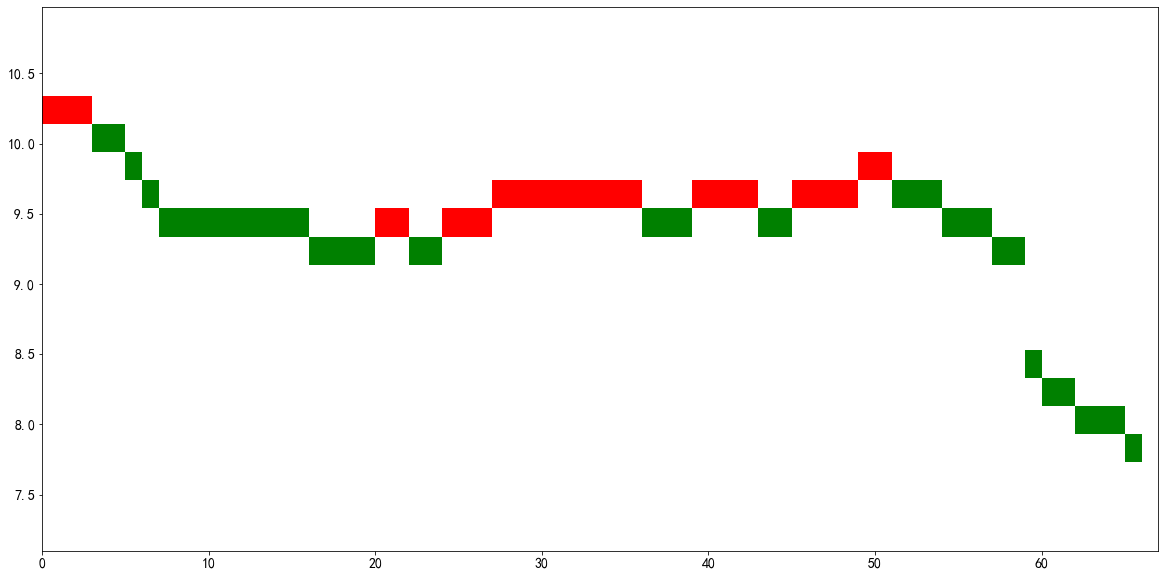

In [322]:
optimal_brick = renko().set_brick_size(auto = True, HLC_history = hlc)
bricks_fixed = renko_chart(hlc.close.values, optimal_brick_sfo,condensed=True)


def plot_renk(bricks, codename=None):
    fig, ax = plt.subplots(1, figsize=(20, 10))
    ax.set_xlim(0.0,len(bricks) + 1.0)
    ax.set_ylim(np.min(bricks[:,3]) - 3.0 * optimal_brick, np.max(bricks[:,3]) + 3.0 * optimal_brick)
    
    for idx, brick in enumerate(bricks):
        facecolor = 'red' if brick[1] > 0 else 'green'
#         print(idx, min(brick[2],brick[3]),abs(brick[3]-brick[2]),facecolor)
        if brick[1] > 0:
            y = min(brick[2],brick[3])
        else:
            y = max(brick[2],brick[3])
        rect = patches.Rectangle(
                        (idx, y), 
                         1, abs(brick[3]-brick[2]),
                         facecolor=facecolor)
        ax.add_patch(rect)


        
plot_renk(bricks_fixed)    

In [326]:
bricks_fixed

array([[10.14      ,  1.        , 10.14      , 10.34079716],
       [10.14      ,  1.        , 10.14      , 10.34079716],
       [10.14      ,  1.        , 10.14      , 10.34079716],
       [-9.93920284, -1.        ,  9.73840568,  9.93920284],
       [-9.93920284, -1.        ,  9.73840568,  9.93920284],
       [-9.73840568, -1.        ,  9.53760852,  9.73840568],
       [-9.53760852, -1.        ,  9.33681136,  9.53760852],
       [-9.33681136, -1.        ,  9.1360142 ,  9.33681136],
       [-9.33681136, -1.        ,  9.1360142 ,  9.33681136],
       [-9.33681136, -1.        ,  9.1360142 ,  9.33681136],
       [-9.33681136, -1.        ,  9.1360142 ,  9.33681136],
       [-9.33681136, -1.        ,  9.1360142 ,  9.33681136],
       [-9.33681136, -1.        ,  9.1360142 ,  9.33681136],
       [-9.33681136, -1.        ,  9.1360142 ,  9.33681136],
       [-9.33681136, -1.        ,  9.1360142 ,  9.33681136],
       [-9.33681136, -1.        ,  9.1360142 ,  9.33681136],
       [-9.1360142 , -1.

In [13]:
renkox.source_aligned

array([[ 9.88753223e-312,  9.88753224e-312,  9.88756642e-312],
       [ 1.01400000e+001,  9.93920284e+000,  0.00000000e+000],
       [ 1.01400000e+001,  9.93920284e+000,  0.00000000e+000],
       [ 9.93920284e+000,  1.01400000e+001, -1.00000000e+000],
       [ 9.93920284e+000,  1.01400000e+001, -1.00000000e+000],
       [ 9.73840568e+000,  9.93920284e+000, -1.00000000e+000],
       [ 9.53760852e+000,  9.73840568e+000, -1.00000000e+000],
       [ 9.33681136e+000,  9.53760852e+000, -1.00000000e+000],
       [ 9.33681136e+000,  9.53760852e+000, -1.00000000e+000],
       [ 9.33681136e+000,  9.53760852e+000, -1.00000000e+000],
       [ 9.33681136e+000,  9.53760852e+000, -1.00000000e+000],
       [ 9.33681136e+000,  9.53760852e+000, -1.00000000e+000],
       [ 9.33681136e+000,  9.53760852e+000, -1.00000000e+000],
       [ 9.33681136e+000,  9.53760852e+000, -1.00000000e+000],
       [ 9.33681136e+000,  9.53760852e+000, -1.00000000e+000],
       [ 9.33681136e+000,  9.53760852e+000, -1.00000000

In [11]:
atr = talib.ATR(high = np.double(hlc.high),
                           low = np.double(hlc.low),
                           close = np.double(hlc.close),
                           timeperiod = 14)
atr = atr[np.isnan(atr) == False]

def evaluate_renko(brick, history, column_name):
    renko_obj = renko()
    renko_obj.set_brick_size(brick_size = brick, auto = False)
    renko_obj.build_history(prices = history)
    return renko_obj.evaluate()[column_name]

optimal_brick_sfo = opt.fminbound(lambda x: -evaluate_renko(brick = x, 
                                  history = hlc.close, 
                                  column_name = 'score'), np.min(atr), np.max(atr), disp=0)

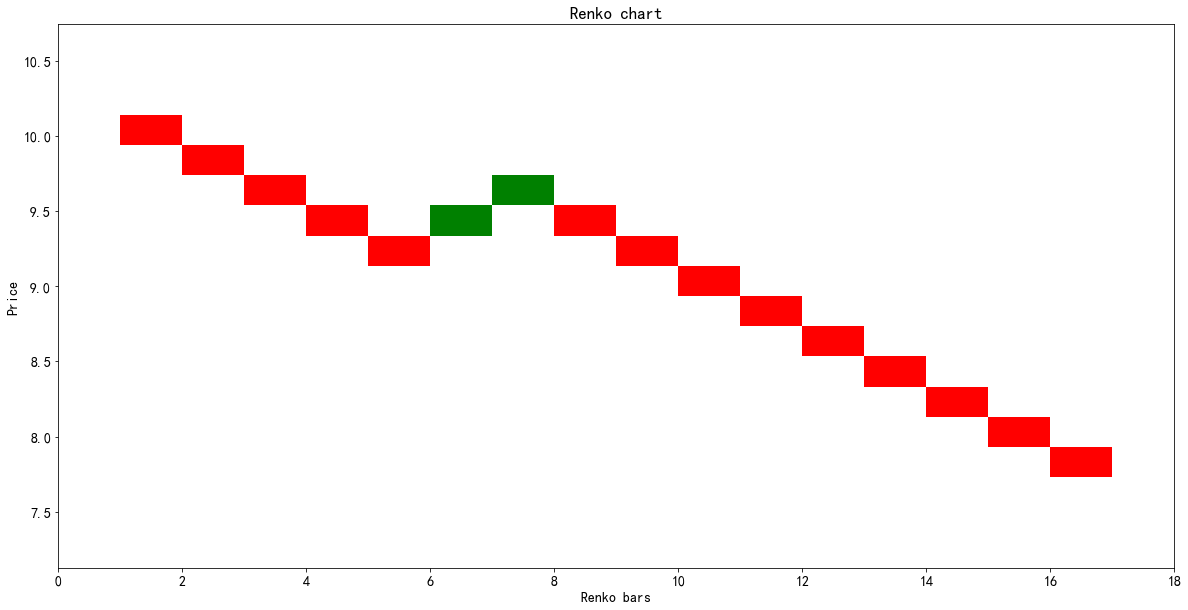

In [12]:
renkox = renko()
renkox.set_brick_size(brick_size = optimal_brick_sfo, auto = False)
renkox.build_history(prices = hlc.close.values)
renkox.plot_renko()


In [259]:
print(optimal_brick)
print(optimal_brick_sfo)

0.7116320764569454
0.8375752245203084


0.2099344791755227


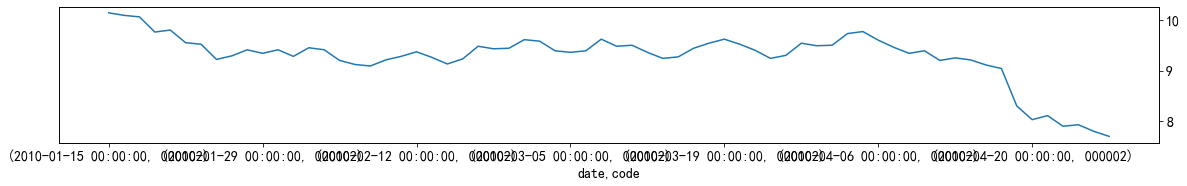

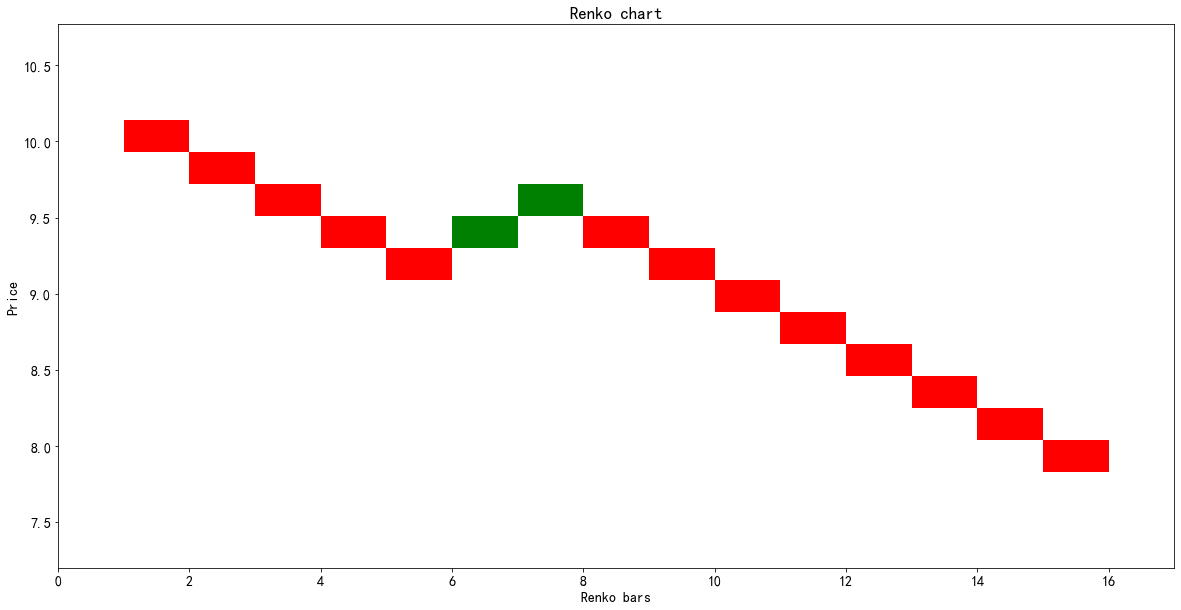

In [325]:


fig = plt.figure(figsize=(1420/72,180/72))
hlc.close.plot(secondary_y=['close'])
r2 = renko()
tmp = r2.set_brick_size(auto = True, HLC_history = hlc)
print(tmp)
r2.build_history(prices=hlc.close.values)
r2.plot_renko()
